In [4]:
import matplotlib
matplotlib.use("Qt5Agg")
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import signal, stats
import mat73
import re
from neurodsp.timefrequency import compute_wavelet_transform
from BCI2kReader import BCI2kReader as b2k
import os
import mne
from tabulate import tabulate
import IPython
import seaborn as sns

In [1]:
%matplotlib qt5

In [2]:
# helper functions#

def rle(inarray):
        """ run length encoding. Partial credit to R rle function. 
            Multi datatype arrays catered for including non Numpy
            returns: tuple (runlengths, startpositions, values) """
        ia = np.asarray(inarray)                # force numpy
        n = len(ia)
        if n == 0: 
            return (None, None, None)
        else:
            y = ia[1:] != ia[:-1]               # pairwise unequal (string safe)
            i = np.append(np.where(y), n - 1)   # must include last element posi
            z = np.diff(np.append(-1, i))       # run lengths
            p = np.cumsum(np.append(0, z))[:-1] # positions
            return(z, p, ia[i])
        
def find_bad_trial_times(idx, srate, trial_begins, trial_lengths):
    ''' takes and index of trial lengths, beginnings and the sampling rate and returns the the start time and and
    duration of the times to annotae as BAD '''
    start_time = trial_begins[0][idx]/srate
    duration = trial_lengths[0][idx]/srate
    
    return start_time[0], duration[0]        

In [15]:
# highpass filter @ 1 and lowpass @ 200 #
filtered_data = mne_df.filter(l_freq=1, h_freq=150) # skip this step for TF analysis, always do this on the least processed data, or do .1 to 250

# remove 60hz line noise #
freqs = (60, 120, 180, 240)
filtered_notch_data = filtered_data.notch_filter(freqs=freqs) 


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1.5e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 150.00 Hz
- Upper transition bandwidth: 37.50 Hz (-6 dB cutoff frequency: 168.75 Hz)
- Filter length: 6601 samples (3.300 sec)

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13201 samples (6.601 sec)



In [11]:
# load/save filtered data

# filtered_notch_data.save('./SLCH002_notched_filtered_ieeg.fif', overwrite = True)
filtered_notch_data = mne.io.Raw('./SLCH002_notched_filtered_ieeg.fif')
events = mne.find_events(filtered_notch_data, output='step', consecutive = False, stim_channel='STI')

Opening raw data file ./SLCH002_notched_filtered_ieeg.fif...
    Range : 0 ... 2373999 =      0.000 ...  1186.999 secs
Ready.
Opening raw data file /home/brooke/pacman_ieeg/SLCH002_notched_filtered_ieeg-1.fif...
    Range : 2374000 ... 2846599 =   1187.000 ...  1423.300 secs
Ready.
480 events found
Event IDs: [0 1]


## Cleaning 

#### Bad Channels

Epileptic channels from my cleaning: 

Epileptic channels from cleaning w/ Rebecca: 

Noisy channels: 

In [12]:
# Remove Channels

# remove non seeg electrodes electrodes #
string_lst = ['EMPTY', 'REF', 'ekg']

bad_channels_reg = [re.findall(r"(?=("+'|'.join(string_lst)+r"))", name, re.IGNORECASE) for name in filtered_notch_data.info['ch_names']]
bad_channels_index = [i for i,x in enumerate(bad_channels_reg) if  x]
bad_channels = [filtered_notch_data.info['ch_names'][i] for i in bad_channels_index]

filtered_notch_data.info['bads'].extend(bad_channels)  

# # remove epileptic electrodes
# filtered_notch_data.info['bads'].append('')
# filtered_notch_data.info['bads'].append('')  
# filtered_notch_data.info['bads'].append('')  
# filtered_notch_data.info['bads'].append('')


# # remove noisy electrodes
# filtered_notch_data.info['bads'].append('')
# filtered_notch_data.info['bads'].append('')  
# filtered_notch_data.info['bads'].append('')  
# filtered_notch_data.info['bads'].append('')

# # remove out of brain electrodes
# filtered_notch_data.info['bads'].append('')
# filtered_notch_data.info['bads'].append('')  
# filtered_notch_data.info['bads'].append('')  
# filtered_notch_data.info['bads'].append('')


# remove scalp and dc channels
scalp_dc_channels = ['FP1',
 'FP2',
 'F7_193',
 'F3_194',
 'FZ',
 'F4_196',
 'F8_197',
 'T7',
 'C3_199',
 'CZ',
 'C4_201',
 'T8',
 'P7',
 'P3',
 'PZ',
 'P4',
 'P8',
 '01',
 '02',
 'DC01',
 'DC02',
 'DC03',
 'DC04',
 'DC05',
 'DC06',
 'DC07',
 'DC08',
 'DC09',
 'DC10',
 'DC11',
 'DC12',
 'DC13',
 'DC14',
 'DC15',
 'DC16']

filtered_notch_data.info['bads'].extend(scalp_dc_channels)
filtered_notch_data

<Raw | SLCH002_notched_filtered_ieeg.fif, 226 x 2846600 (1423.3 s), ~227 kB, data not loaded>

#### Bad Epochs


In [13]:
# Annotate Noisy Epochs from Bob's cleaning

# onsets = [
#     filtered_notch_data.first_time + 115,
#     filtered_notch_data.first_time + 127,
#     filtered_notch_data.first_time + 160,
#     filtered_notch_data.first_time + 343,
#     filtered_notch_data.first_time + 540,
#     filtered_notch_data.first_time + 621,
#     filtered_notch_data.first_time + 681,
#     filtered_notch_data.first_time + 1224,
#     filtered_notch_data.first_time + 1268,
#     filtered_notch_data.first_time + 1443,
#     filtered_notch_data.first_time + 1507,
#     filtered_notch_data.first_time + 1555,
#     filtered_notch_data.first_time + 1573,
#     filtered_notch_data.first_time + 1697,
#     filtered_notch_data.first_time + 1787,
#     filtered_notch_data.first_time + 1903,
#     filtered_notch_data.first_time + 1984,
#     filtered_notch_data.first_time + 2217,
#     filtered_notch_data.first_time + 2423.5,
#     filtered_notch_data.first_time + 2515,
#     filtered_notch_data.first_time + 2526.5,
#     filtered_notch_data.first_time + 2557,
#     filtered_notch_data.first_time + 2762
    
# ]

# # 520, 1; 561, 1; 2588, 1; 2629, 1;

# durations = [2, 2, 2, 2, 1, 2, 2, 1, 2, 1, 1, 2, 2, 1, 1.5, 1, 1, 1.5, 1, 2, 2, 2]


In [14]:
## quality check trials ##

# # calculate trial onsets and offsets
# sti_raw = filtered_notch_data.get_data(picks = ['STI'])
# lengths, positionsm, val  = rle(sti_raw[0])

# # lengths, beginnings, endings, for trials
# trial_lengths = [lengths[x] for x in np.where(val == 1)]
# trial_begins = [positionsm[x] for x in np.where(val == 1)]
# trial_ends = trial_lengths[0] + trial_begins[0]
# trial_baseline = trial_begins[0] - 1000

# # lengths, beginnings, endings, for itis
# iti_lengths = [lengths[x] for x in np.where(val == 0)]
# iti_begins = [positionsm[x] for x in np.where(val == 0)]
# iti_ends = iti_begins[0] + iti_lengths[0]

In [15]:
# exclude bad trials/apochs via nnotations

# # exclude long 30s trial
# bad_trial_idx = np.where(trial_lengths[0]/2000 > 30)[0]
# start, dur = find_bad_trial_times(bad_trial_idx, 2000, trial_begins, trial_lengths)

# onsets.append(start)
# durations.append(dur)
# descriptions = ['bad'] * len(durations)

# # exclude very short trial
# bad_trial_idx = [34]
# start, dur = find_bad_trial_times(bad_trial_idx, 2000, trial_begins, trial_lengths)
# onsets.append(start)
# durations.append(dur)
# descriptions = ['bad'] * len(durations)

# # exclude glitchy trial
# bad_trial_idx = [68]
# start, dur = find_bad_trial_times(bad_trial_idx, 2000, trial_begins, trial_lengths)
# onsets.append(start)
# durations.append(dur)
# descriptions = ['bad'] * len(durations)

# bad_annots = mne.Annotations(onset=onsets,
#                                duration=durations,
#                                description=descriptions,
#                                orig_time=filtered_notch_data.info['meas_date'])
# filtered_notch_data.set_annotations(bad_annots)

next step, working on filtering out the high frequency noise

then look at Marks script to come up with some plot of every trial, sort longest to shortest, with theta power as the color tiome as x, trial on y

Opening raw-browser...


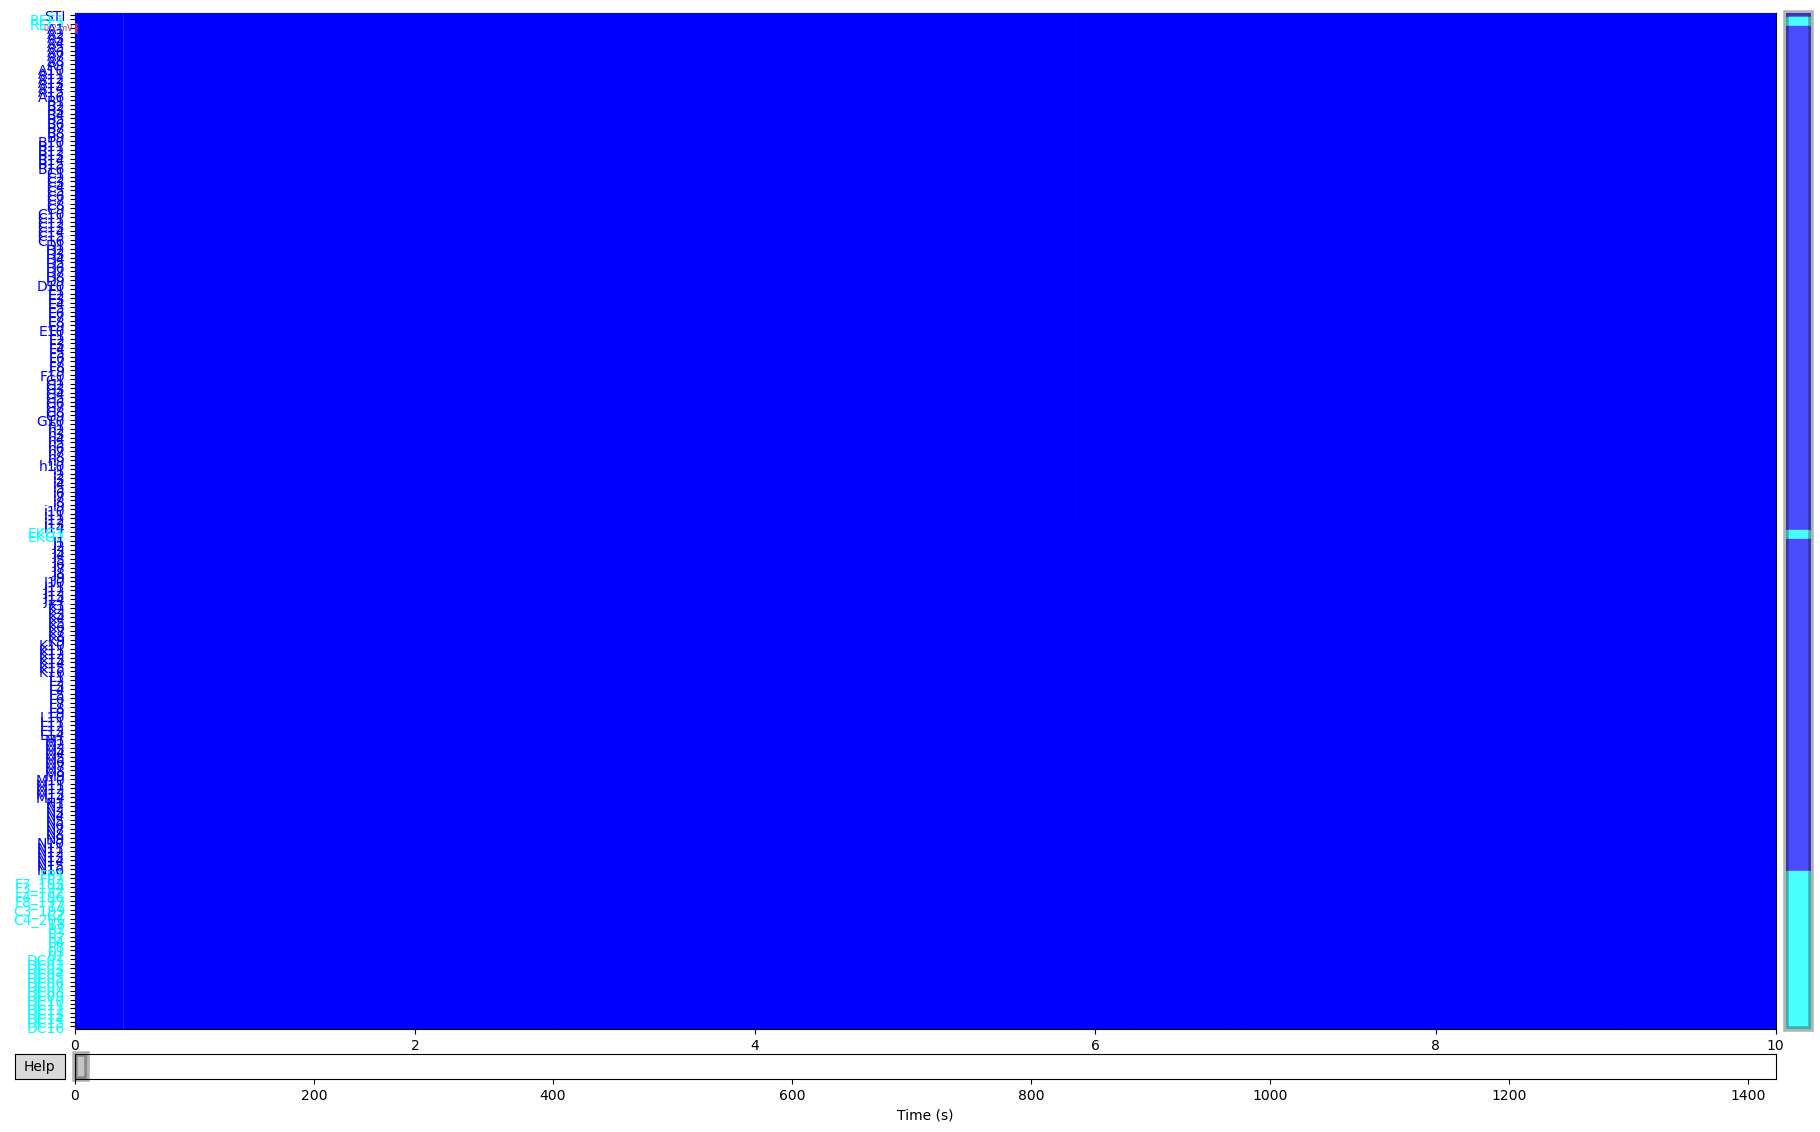

Closing raw-browser...
Channels marked as bad:
['REF1', 'REF2', 'EKG1', 'EKG2', 'FP1', 'FP2', 'F7_193', 'F3_194', 'FZ', 'F4_196', 'F8_197', 'T7', 'C3_199', 'CZ', 'C4_201', 'T8', 'P7', 'P3', 'PZ', 'P4', 'P8', '01', '02', 'DC01', 'DC02', 'DC03', 'DC04', 'DC05', 'DC06', 'DC07', 'DC08', 'DC09', 'DC10', 'DC11', 'DC12', 'DC13', 'DC14', 'DC15', 'DC16', 'J1', 'J2', 'J3', 'B2', 'B1', 'A1', 'A2', 'i5', 'i4', 'K2', 'D5', 'D6', 'E7']


In [16]:

filtered_notch_data.plot(events=events, color='b', bad_color = 'cyan', n_channels = 230, clipping = None, event_color = 'r')